## Play with left and right eye data
### Reference
1. How to Synchroniza Time Series Datasets in Python. https://towardsdatascience.com/how-to-synchronize-time-series-datasets-in-python-f2ae51bee212.
2. Specifications about Pupil Labs's Pupil Core. https://docs.pupil-labs.com/core/best-practices/.

### Implemetation

In [1]:
import pandas as pd
import numpy as np
import math, os
from numba import jit
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def plotter(ax, data1, data2, param_dict):
    out = ax.plot(data1, data2, **param_dict)
    return out

According to Pupil Labs's specification, since our experiments are conducting studies in the mobile setting, we'd better use 3D pipeline, i.e., use data generated by 3D models.

In [2]:
# Interactive section
# Read left and right eyes' data from the raw preprocessing file.
%store -r read_left_file_path
%store -r read_right_file_path
left_eye_filepath = read_left_file_path
right_eye_filepath = read_right_file_path

# Get the sampling rate labels
SR_LEFT = int((left_eye_filepath.split('_')[-1]).split('Hz')[0])
SR_RIGHT = int((right_eye_filepath.split('_')[-1]).split('Hz')[0])

# Configure the parameters
entity_dwt_align = 'Timestamp'
entity_dwt_apply_dia = 'Diameter'
entity_dwt_apply_conf = 'Confidence'
left_eye = 'left'
right_eye = 'right'
base_eye = left_eye  # The eye that resample another eye to its dimension. In this pipeline I am using the up-sampling method so it is the eye with more data.

In [3]:
# Tag labels
SAMPLING_RATE_LEFT = int((left_eye_filepath.split('_')[-1]).split('Hz')[0])
data_left = pd.read_csv(left_eye_filepath)

SAMPLING_RATE_RIGHT = int((right_eye_filepath.split('_')[-1]).split('Hz')[0])
data_right = pd.read_csv(right_eye_filepath)

In [4]:
df_left = data_left[['Timestamp','Confidence','Diameter','Event']].copy()
df_right = data_right[['Timestamp','Confidence','Diameter','Event']].copy()

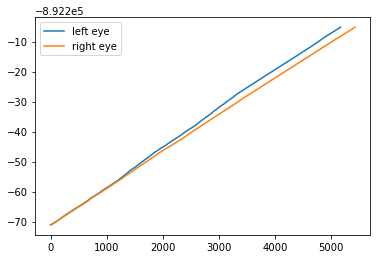

In [5]:
# Plot to get a brief look over the 2 sets data and the gap between them.
fig, ax = plt.subplots()
df_left[entity_dwt_align].plot(ax=ax)
df_right[entity_dwt_align].plot(ax=ax)
ax.legend(["left eye", "right eye"])

In [6]:
# Calculate two signals' correlation as a reference.
# Determine the left and right eye data's size first: which one is bigger?
len_raw_left = len(df_left[entity_dwt_align])
len_raw_right = len(df_right[entity_dwt_align])

# If the left eye's data size is bigger
if len_raw_left >= len_raw_right:
    correlation = r2_score(df_left[entity_dwt_apply_dia][:len(df_right[entity_dwt_apply_dia])], 
                           df_right[entity_dwt_apply_dia])
elif len_raw_left < len_raw_right:
    correlation = r2_score(df_left[entity_dwt_apply_dia], 
                           df_right[entity_dwt_apply_dia][:len(df_left[entity_dwt_apply_dia])])

correlation

-1.1643567934455583

### Synchronize with dynamic time warper method
While this method does not rely on the timestamp, soly on data values.

In [7]:
# Identify the number of elements in the left/right eyes data. If one applies the up-sampling method, the larger eye needs to be put in the first argument.
len_left = len(df_left)
len_right = len(df_right)
if len_left >= len_right:
    base_eye = left_eye
    df_reference = df_left.copy()  # df_reference: the one that being put in the first argument, as a reference.
    df_alignment = df_right.copy() # df_alignment: the one that being put in the second argument, to be aligned to the reference.
elif len_left < len_right:
    base_eye = right_eye
    df_reference = df_right.copy()
    df_alignment = df_left.copy()

In [8]:
# Calculate for warping.
distance, path = fastdtw(df_reference[entity_dwt_align], df_alignment[entity_dwt_align], dist=euclidean)

In [9]:
len(df_reference[entity_dwt_align]), len(df_alignment[entity_dwt_align]), len(path)

(5424, 5167, 5524)

In [10]:
# Assuming the left eye is the reference eye.
result = []
for i in range(0, len(path)):
    result.append([path[i][0],
                   df_reference[entity_dwt_apply_dia].iloc[path[i][0]],
                   df_alignment[entity_dwt_apply_dia].iloc[path[i][1]]])
df_sync = pd.DataFrame(data=result,columns=['Index', 
                                            'Reference '+entity_dwt_apply_dia, 
                                            'Alignment '+entity_dwt_apply_dia]).dropna()
df_sync = df_sync.drop_duplicates(subset=['Index'])
df_sync = df_sync.reset_index(drop=True)
df_sync

,Index,Reference Diameter,Alignment Diameter
0,0,13.674340,16.634724
1,1,14.194145,16.773325
2,2,14.074131,17.485968
3,3,13.261177,16.751875
4,4,13.576944,16.769070
...,...,...,...
5419,5419,13.373928,14.666103
5420,5420,13.601045,14.737844
5421,5421,13.324729,14.289388
5422,5422,13.621338,14.488173


In [11]:
correlation = r2_score(df_sync['Reference '+entity_dwt_apply_dia], 
                       df_sync['Alignment '+entity_dwt_apply_dia])
correlation

-0.49122400031021773

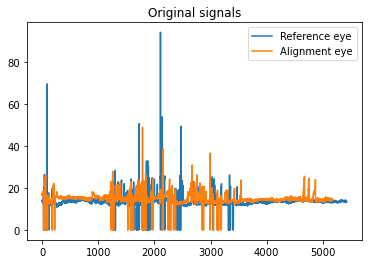

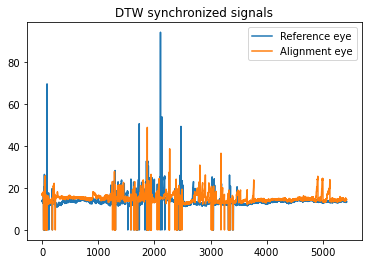

In [12]:
# Plot to get a brief look over the 2 sets data and the gap between them.
fig_orig, ax_orig = plt.subplots()
df_reference[entity_dwt_apply_dia].plot(ax=ax_orig)
df_alignment[entity_dwt_apply_dia].plot(ax=ax_orig, title = 'Original signals')
ax_orig.legend(["Reference eye", "Alignment eye"])

# Plot to get a brief look over the 2 sets of synchronized data and the gap between them.
fig_sync, ax_sync = plt.subplots()
df_sync['Reference '+entity_dwt_apply_dia].plot(ax=ax_sync)
df_sync['Alignment '+entity_dwt_apply_dia].plot(ax=ax_sync, title = 'DTW synchronized signals')
ax_sync.legend(["Reference eye", "Alignment eye"])

Seems a lot of data are missing compared to the original signals. Maybe change other methods.

### Synchronize according to given timestamps
There is a column called "World Index", I will try directly synchornizing 2 eyes' data using this metric. https://docs.pupil-labs.com/core/terminology/

The pye3d model regularly updates to account for headset slippage. In certain situations, this can lead to incorrect pupil size estimates.

I planned to use 3D model's data due to studies' mobility, however 2 eyes' data did not show any correlation, cannot be synchronized at all, hence I used 2D model's data.

Check the matching algorithm part: https://docs.pupil-labs.com/developer/core/overview/#matching-algorithm.

Already satisfied with the parameter configured as: \
entity_dwt_align = 'Timestamp' \
entity_dwt_apply = 'Diameter'

### Align/merge data

In [13]:
# Define a function scnchronize and align/merge 2 eyes' numerical values, including diamter and confidence values.
# The method of getting the average/mean value of 2 eyes' data as computing target is referenced from the mention in LHIPA.
def synchronize_merge_data(path_dwt, df_reference, df_alignment, entity_dwt_apply):
    # Synchronize
    data_sync = []
    for i in range(0, len(path_dwt)):
        data_sync.append([path_dwt[i][0],  # The index column is for dropping out duplicates.
                         df_reference[entity_dwt_apply].iloc[path_dwt[i][0]],
                         df_alignment[entity_dwt_apply].iloc[path_dwt[i][1]]])
    df_sync = pd.DataFrame(data=data_sync,
                           columns=['Index', 
                                    'Reference '+entity_dwt_apply, 
                                    'Alignment '+entity_dwt_apply]).dropna()
    df_sync = df_sync.drop_duplicates(subset=['Index']) # Drop the duplicates according to the index of the reference.
    df_sync = df_sync.reset_index(drop=True)
    # Merge/Align
    df_sync['Avg'+entity_dwt_apply] = df_sync.loc[:, ['Reference '+entity_dwt_apply, 'Alignment '+entity_dwt_apply]].mean(axis = 1)
    return df_sync

In [14]:
# Synchronize and merge
df_sync_dia = synchronize_merge_data(path_dwt=path,
                                     df_reference=df_reference,
                                     df_alignment=df_alignment,
                                     entity_dwt_apply=entity_dwt_apply_dia
                                     )
df_sync_conf = synchronize_merge_data(path_dwt=path,
                                      df_reference=df_reference,
                                      df_alignment=df_alignment,
                                      entity_dwt_apply=entity_dwt_apply_conf
                                      )

In [15]:
df_sync_dia

,Index,Reference Diameter,Alignment Diameter,AvgDiameter
0,0,13.674340,16.634724,15.154532
1,1,14.194145,16.773325,15.483735
2,2,14.074131,17.485968,15.780049
3,3,13.261177,16.751875,15.006526
4,4,13.576944,16.769070,15.173007
...,...,...,...,...
5419,5419,13.373928,14.666103,14.020016
5420,5420,13.601045,14.737844,14.169444
5421,5421,13.324729,14.289388,13.807058
5422,5422,13.621338,14.488173,14.054755


In [16]:
df_sync_conf

,Index,Reference Confidence,Alignment Confidence,AvgConfidence
0,0,0.807645,0.667318,0.737482
1,1,0.904619,0.888107,0.896363
2,2,0.742808,0.753639,0.748223
3,3,0.914601,0.677938,0.796269
4,4,0.878958,0.712267,0.795613
...,...,...,...,...
5419,5419,0.968729,0.837138,0.902934
5420,5420,1.000000,0.758775,0.879388
5421,5421,0.936766,0.860170,0.898468
5422,5422,0.905997,0.830478,0.868238


### Output for the raw data preprocessing
The final step is integrating timestamp and event labels. Directly drag data from the bigger data between left and right eye data, because dwt aligh data according to the bigger one, to keep shape consistency.

In [17]:
# Create a new empty data frame
df_to_raw_preprocess = pd.DataFrame()

# If the left eye's data size is bigger
if len_raw_left >= len_raw_right:
    df_origin = df_left.copy()
    SR = SR_LEFT
elif len_raw_left < len_raw_right:
    df_origin = df_right.copy()
    SR = SR_RIGHT

df_to_raw_preprocess['Timestamp'] = df_origin['Timestamp']
df_to_raw_preprocess['Confidence'] = df_sync_conf['AvgConfidence']
df_to_raw_preprocess['Diameter'] = df_sync_dia['AvgDiameter']
df_to_raw_preprocess['Event'] = df_origin['Event']

In [18]:
df_to_raw_preprocess

,Timestamp,Confidence,Diameter,Event
0,-892271.088994,0.737482,15.154532,default
1,-892271.080066,0.896363,15.483735,default
2,-892271.071860,0.748223,15.780049,default
3,-892271.062606,0.796269,15.006526,default
4,-892271.055941,0.795613,15.173007,default
...,...,...,...,...
5419,-892205.294785,0.902934,14.020016,sitting
5420,-892205.279504,0.879388,14.169444,sitting
5421,-892205.269302,0.898468,13.807058,sitting
5422,-892205.256027,0.868238,14.054755,sitting


In [19]:
# Write to csv to archieve data.
df_export = df_to_raw_preprocess.copy()
file_name = left_eye_filepath.split('/')[-2:]

folder_path = '../Data/PreprocessedData/' + file_name[0] + '/'
if os.path.exists(folder_path) is False:
    os.makedirs(folder_path)

write_file_name = 'synchronized_' + str(SR) + 'Hz.csv'
write_file_path = folder_path + write_file_name
df_export.to_csv(write_file_path)